## Walmart sale forecat-EDA

### In this notebook, I will explore the data & identify top revenue generators


### 1.1 Import Librries

In [2]:
import pandas as pd
import numpy as np
import warnings

from  datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import category_encoders as ce
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

### 1.2 Read in data
Data Soutce: https://www.kaggle.com/c/m5-forecasting-accuracy/data

In [3]:
calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')
sales_train_val = pd.read_csv('sales_train_validation.csv')

### 1.2.1. Calendar Data Frame

In [4]:
calendar.head(3).append(calendar.tail(2))

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [5]:
calendar.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

In [6]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


### Fill NaN values with '0' for Label encoding ( will be useful in 2d notebook)

In [7]:
calendar = calendar.replace(np.nan,'0')

In [8]:
### label encode events

names = pd.concat([calendar['event_name_1'],calendar['event_name_2']])
types = pd.concat([calendar['event_type_1'],calendar['event_type_2']])

le = LabelEncoder()
names = le.fit_transform(names)
types = le.fit_transform(types)

In [9]:
categorical = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
encoded = [names[:1969], types[:1969], names[1969:], types[1969:]]
encoded = pd.DataFrame(np.array(encoded).transpose(), columns = categorical)
del names, types

In [10]:
# check encoding
# calendar.loc[(calendar['event_type_1']=='Cultural')|(calendar['event_type_2']=='Cultural')]

In [11]:
# concat encoded columns back to the calendar df
calendar.drop(columns = categorical , inplace=True)
calendar = pd.concat([calendar, encoded],axis=1)
calendar.head(4).append(calendar.tail(2))

,date,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2
0,2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,0,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,0,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,1,1,0,0,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,0,0,0,0,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,0,0,0,17,4,8,1


### Convert dtype for memory optimization

In [13]:
calendar['date'] = pd.to_datetime(calendar['date'])
# calendar.set_index('date', inplace=True)

# get some features from the date that not in the calendar dataframe 
calendar['day'] = calendar['date'].dt.day.astype(np.int8)
calendar['week'] = calendar['date'].dt.week.astype(np.int8)

# convert d column to numerical
calendar['d'] = calendar['d'].apply(lambda x: x[2:]).astype(np.int16)

# prepare list of columns to data reducing

col_int8 = ['wday','month','snap_TX',
            'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'] 
### !!! Note: Dont forget to add snap_TX, snap_WI for all data

col_int16 = ['wm_yr_wk','year']
categ = ['weekday']

# convert dtypes:

for i in col_int8:
    calendar[i] = calendar[i].astype(np.int8)
    
for i in col_int16:
    calendar[i] = calendar[i].astype(np.int16)

for i in categ:
    calendar[i] = calendar[i].astype('category')

In [23]:
### Reduce to week #11613 or day 1913 per available train and validation data
calendar = calendar.loc[calendar['d']<=1913]

In [24]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1913 entries, 0 to 1912
Data columns (total 16 columns):
date            1913 non-null datetime64[ns]
wm_yr_wk        1913 non-null int16
weekday         1913 non-null category
wday            1913 non-null int8
month           1913 non-null int8
year            1913 non-null int16
d               1913 non-null int16
snap_CA         1913 non-null int64
snap_TX         1913 non-null int8
snap_WI         1913 non-null int64
event_name_1    1913 non-null int8
event_type_1    1913 non-null int8
event_name_2    1913 non-null int8
event_type_2    1913 non-null int8
day             1913 non-null int8
week            1913 non-null int8
dtypes: category(1), datetime64[ns](1), int16(3), int64(2), int8(9)
memory usage: 90.0 KB


### 1.2.2. Sell_prices data frame

In [18]:
sell_prices.head(3).append(sell_prices.tail(2))

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,FOODS_1_001,11101,2.00
1,CA_2,FOODS_1_001,11101,2.00
2,CA_3,FOODS_1_001,11101,2.00
6841119,WI_2,HOUSEHOLD_2_516,11621,5.94
6841120,WI_3,HOUSEHOLD_2_516,11621,5.94


In [16]:
# Sort by values and reset index
sell_prices = sell_prices.sort_values(by=['item_id','wm_yr_wk'])
sell_prices.reset_index(inplace=True)
del sell_prices["index"]

In [19]:
sell_prices.head(3).append(sell_prices.tail(2))

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,FOODS_1_001,11101,2.00
1,CA_2,FOODS_1_001,11101,2.00
2,CA_3,FOODS_1_001,11101,2.00
6841119,WI_2,HOUSEHOLD_2_516,11621,5.94
6841120,WI_3,HOUSEHOLD_2_516,11621,5.94


### Convert dtype for memory optimization

In [20]:
sell_prices['store_id'] = sell_prices['store_id'].astype('category')
sell_prices['item_id'] = sell_prices['item_id'].astype('category')
sell_prices['wm_yr_wk'] = sell_prices['wm_yr_wk'].astype(np.int16)

### Reduce to week #11613 or day 1913 per available train and validation data

In [21]:
sell_prices = sell_prices.loc[sell_prices['wm_yr_wk']<=11613]

In [25]:
sell_prices.head(2).append(sell_prices.tail(3))

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,FOODS_1_001,11101,2.00
1,CA_2,FOODS_1_001,11101,2.00
6841038,WI_1,HOUSEHOLD_2_516,11613,5.94
6841039,WI_2,HOUSEHOLD_2_516,11613,5.94
6841040,WI_3,HOUSEHOLD_2_516,11613,5.94


### 1.2.3. Sales_train_validation Data Frame

In [27]:
sales_train_val.head(3).append(sales_train_val.tail(2))

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3
30489,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
sales_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


### Create more data points by changing horizontal orientation of d_1, d_2, ... columns

In [29]:
used_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

sales_train_val = pd.melt(sales_train_val,
                          used_columns,
                          var_name='d',
                          value_name='sales')

In [30]:
sales_train_val.head(3).append(sales_train_val.tail(2))

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3
58327369,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1913,0


### Convert dtype for memory optimization

In [31]:
### rename sales_train_val to df_sales
df_sales = sales_train_val.copy()
del sales_train_val

In [32]:
# optimize data
df_sales['d'] = df_sales['d'].apply(lambda x: x[2:])
df_sales['d'] = df_sales['d'].astype(np.int16)
df_sales['sales'] = df_sales['sales'].astype(np.int16)

for col in used_columns:
    df_sales[col] = df_sales[col].astype('category')

In [33]:
df_sales.head(3).append(df_sales.tail(2))

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1913,3
58327369,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1913,0


In [35]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 8 columns):
id          category
item_id     category
dept_id     category
cat_id      category
store_id    category
state_id    category
d           int16
sales       int16
dtypes: category(6), int16(2)
memory usage: 669.1 MB


### 1.3 Merge in one data frame


In [36]:
df_sales.head(3).append(df_sales.tail(2))

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1913,3
58327369,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1913,0


In [37]:
calendar.head(3).append(calendar.tail(2))

,date,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2,day,week
0,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,0,0,0,0,29,4
1,2011-01-30,11101,Sunday,2,1,2011,2,0,0,0,0,0,0,0,30,4
2,2011-01-31,11101,Monday,3,1,2011,3,0,0,0,0,0,0,0,31,5
1911,2016-04-23,11613,Saturday,1,4,2016,1912,0,0,0,0,0,0,0,23,16
1912,2016-04-24,11613,Sunday,2,4,2016,1913,0,0,0,0,0,0,0,24,16


In [38]:
sell_prices.head(3).append(sell_prices.tail(2))

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,FOODS_1_001,11101,2.00
1,CA_2,FOODS_1_001,11101,2.00
2,CA_3,FOODS_1_001,11101,2.00
6841039,WI_2,HOUSEHOLD_2_516,11613,5.94
6841040,WI_3,HOUSEHOLD_2_516,11613,5.94


### 1.3.1. Merge df_sales and calendar data frame

In [39]:
df_sales = df_sales.merge(calendar,on='d')

In [40]:
df_sales.head(3).append(df_sales.tail(2))

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,year,snap_CA,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2,day,week
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,2011,0,0,0,0,0,0,0,29,4
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,2011,0,0,0,0,0,0,0,29,4
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,2011,0,0,0,0,0,0,0,29,4
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1913,3,2016-04-24,11613,...,2016,0,0,0,0,0,0,0,24,16
58327369,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1913,0,2016-04-24,11613,...,2016,0,0,0,0,0,0,0,24,16


In [43]:
df_sales.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'snap_CA', 'snap_TX', 'snap_WI', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'day', 'week'],
      dtype='object')

### 1.3.2. Merge df_sales and sell_price data frame

In [44]:
df_sales = df_sales.merge(sell_prices, on=['store_id','item_id','wm_yr_wk'])

In [47]:
# rename data frame as df and delete everything else
df=df_sales.copy()
del df_sales, sell_prices, calendar

In [50]:
# create revenue column
df['revenue'] = df['sales'] * df['sell_price']

In [51]:
df.head(3).append(df.tail(2))

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2,day,week,sell_price,revenue
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12,2011-01-29,11101,...,0,0,0,0,0,0,29,4,0.46,5.52
1,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,2,15,2011-01-30,11101,...,0,0,0,0,0,0,30,4,0.46,6.90
2,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,3,0,2011-01-31,11101,...,0,0,0,0,0,0,31,5,0.46,0.00
46027955,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1912,0,2016-04-23,11613,...,0,0,0,0,0,0,23,16,1.00,0.00
46027956,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1913,0,2016-04-24,11613,...,0,0,0,0,0,0,24,16,1.00,0.00


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 25 columns):
id              category
item_id         category
dept_id         category
cat_id          category
store_id        category
state_id        category
d               int16
sales           int16
date            datetime64[ns]
wm_yr_wk        int16
weekday         category
wday            int8
month           int8
year            int16
snap_CA         int64
snap_TX         int8
snap_WI         int64
event_name_1    int8
event_type_1    int8
event_name_2    int8
event_type_2    int8
day             int8
week            int8
sell_price      float64
revenue         float64
dtypes: category(7), datetime64[ns](1), float64(2), int16(4), int64(2), int8(9)
memory usage: 3.2 GB


## 2. Create plots for presentation

### 2.1  Revenue per day of the week

In [53]:
tmp_1 = df.groupby(['store_id','weekday'])[['revenue']].sum()

In [54]:
tmp_1.reset_index(inplace=True)

In [56]:
tmp_1.head(3).append(tmp_1.tail(2))

,store_id,weekday,revenue
0,CA_1,Friday,3.187820e+06
1,CA_1,Monday,3.098223e+06
2,CA_1,Saturday,4.063114e+06
68,WI_3,Tuesday,2.133175e+06
69,WI_3,Wednesday,2.086055e+06


In [57]:
# create temporary df-s for each store
ca_1 = tmp_1[(tmp_1['store_id']=='CA_1')]
ca_2 = tmp_1[(tmp_1['store_id']=='CA_2')]
ca_3 = tmp_1[(tmp_1['store_id']=='CA_3')]
ca_4 = tmp_1[(tmp_1['store_id']=='CA_4')]

tx_1 = tmp_1[(tmp_1['store_id']=='TX_1')]
tx_2 = tmp_1[(tmp_1['store_id']=='TX_2')]
tx_3 = tmp_1[(tmp_1['store_id']=='TX_3')]

wi_1 = tmp_1[(tmp_1['store_id']=='WI_1')]
wi_2 = tmp_1[(tmp_1['store_id']=='WI_2')]
wi_3 = tmp_1[(tmp_1['store_id']=='WI_3')]

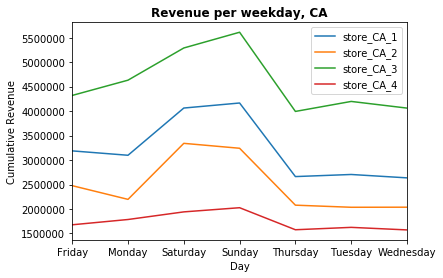

In [58]:
# gca stands for 'get current axis'
ax = plt.gca()

ca_1.plot(kind='line',x='weekday',y='revenue',label = 'store_CA_1', ax=ax)
ca_2.plot(kind='line',x='weekday',y='revenue',label = 'store_CA_2',ax=ax)
ca_3.plot(kind='line',x='weekday',y='revenue',label = 'store_CA_3', ax=ax)
ca_4.plot(kind='line',x='weekday',y='revenue',label = 'store_CA_4', ax=ax)


plt.legend(loc='upper right')

# Add title and x, y labels
plt.title("Revenue per weekday, CA", fontsize=12, fontweight='bold')
plt.xlabel('Day')
plt.ylabel("Cumulative Revenue")
plt.show()
plt.show()

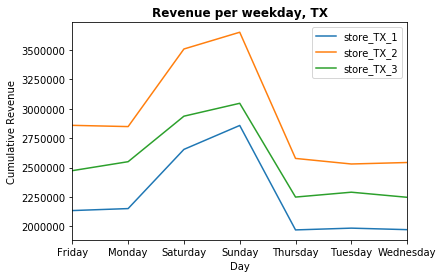

In [61]:
# gca stands for 'get current axis'
ax = plt.gca()

tx_1.plot(kind='line',x='weekday',y='revenue',label = 'store_TX_1', ax=ax)
tx_2.plot(kind='line',x='weekday',y='revenue',label = 'store_TX_2',ax=ax)
tx_3.plot(kind='line',x='weekday',y='revenue',label = 'store_TX_3', ax=ax)


plt.legend(loc='upper right')

# Add title and x, y labels
plt.title("Revenue per weekday, TX", fontsize=12, fontweight='bold')
plt.xlabel('Day')
plt.ylabel("Cumulative Revenue")
plt.show()
plt.show()

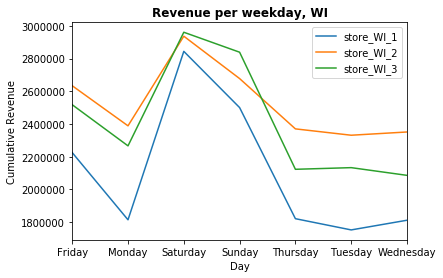

In [62]:
# gca stands for 'get current axis'
ax = plt.gca()

wi_1.plot(kind='line',x='weekday',y='revenue',label = 'store_WI_1', ax=ax)
wi_2.plot(kind='line',x='weekday',y='revenue',label = 'store_WI_2',ax=ax)
wi_3.plot(kind='line',x='weekday',y='revenue',label = 'store_WI_3', ax=ax)


plt.legend(loc='upper right')

# Add title and x, y labels
plt.title("Revenue per weekday, WI", fontsize=12, fontweight='bold')
plt.xlabel('Day')
plt.ylabel("Cumulative Revenue")
plt.show()
plt.show()

### 2.2  Items that generate the most revenue (Top revenue generators)

In [67]:
## total revenue in $ mln
df.revenue.sum()/10**6

187.67657001999945

In [68]:
tmp_2 = df.groupby(['item_id','cat_id'])[['revenue']].sum().sort_values(by='revenue', ascending=False)

In [69]:
# 50% of revenue by each category
tmp_3 = tmp_2[:420].groupby('cat_id')['revenue'].sum()
tmp_3

cat_id
FOODS        6.273233e+07
HOBBIES      8.758978e+06
HOUSEHOLD    2.239120e+07
Name: revenue, dtype: float64

In [70]:
# % of total items that generate total revenue
420/3049

0.1377500819940964

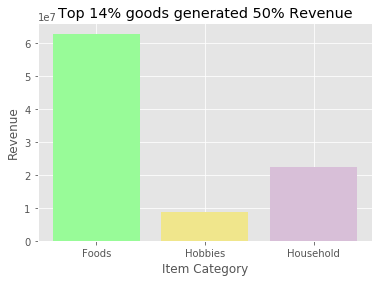

In [71]:
plt.style.use('ggplot')

x = ['Foods', 'Hobbies', 'Household']
energy = [6.273233e+07, 8.758978e+06, 2.239120e+07]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy, color=['palegreen','khaki','thistle'])
plt.xlabel("Item Category")
plt.ylabel("Revenue")
plt.title("Top 14% goods generated 50% Revenue")

plt.xticks(x_pos, x)

plt.show()

### 2.3  Dollar sales per store and state

In [72]:
tmp_3 = df.groupby('store_id')[['revenue']].sum().reset_index()

In [73]:
tmp_3

,store_id,revenue
0,CA_1,2.252025e+07
1,CA_2,1.740944e+07
2,CA_3,3.210872e+07
3,CA_4,1.220715e+07
4,TX_1,1.572916e+07
5,TX_2,2.051824e+07
6,TX_3,1.779673e+07
7,WI_1,1.476924e+07
8,WI_2,1.769074e+07
9,WI_3,1.692691e+07


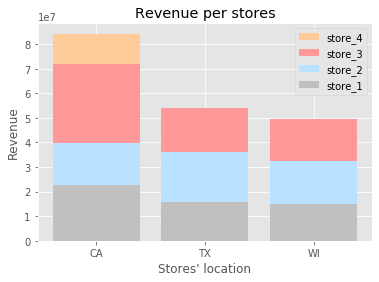

In [74]:
states = ['CA', 'TX', 'WI']
level_3 = np.array([2.252025e+07, 1.572916e+07, 1.476924e+07])
level_2 = np.array([1.740944e+07, 2.051824e+07, 1.769074e+07])
level_1 = np.array([3.210872e+07, 1.779673e+07, 1.692691e+07])
level_0 = np.array([1.220715e+07, 0, 0])

ind = [x for x, _ in enumerate(states)]

plt.bar(ind, level_0, width=0.8, label='store_4', color='#ffcc99', bottom=level_1+level_2+level_3)
plt.bar(ind, level_1, width=0.8, label='store_3', color='#ff9999', bottom=level_2+level_3)
plt.bar(ind, level_2, width=0.8, label='store_2', color='#bae1ff', bottom=level_3)
plt.bar(ind, level_3, width=0.8, label='store_1', color='silver')#, bottom = golds)


plt.xticks(ind, states)
plt.ylabel("Revenue")
plt.xlabel("Stores' location")
plt.legend(loc="upper right")
plt.title("Revenue per stores")

plt.show()

### 2.4  Dollar sales per category

In [77]:
df.groupby('cat_id')[['revenue']].sum()

,revenue
cat_id,
FOODS,1.089046e+08
HOBBIES,2.281841e+07
HOUSEHOLD,5.595354e+07


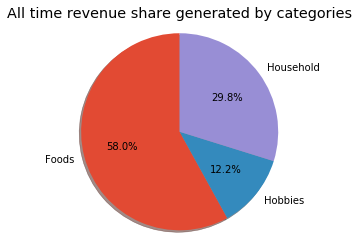

In [78]:
# import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Foods', 'Hobbies', 'Household'
sizes =  [1.089046e+08, 2.281841e+07, 5.595354e+07] #[15, 30, 45, 10]
explode = (0.1, 0.1, 0.1)  # "explode"  slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('All time revenue share generated by categories')
plt.show()

In [81]:
### save df 
df.to_csv('wm_sales.csv')